In [2]:
from notebooks.presets import set_cwd
set_cwd()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

from src.embeddings.magnitude_spectrum import embedding_vector
from src.embeddings.seq2img_embeddings import s2i_vector
from src.embeddings.shape_based import paa, sax
from src.embeddings.simple_statistics import simple_statistics_vector
from src.data_generation.simple_data_generation import shift_time_series, shrunk_time_series

In [3]:
def grouped_bars(data, labels=None, series_labels=None, width=0.8, logarithmic_scale=True):
    """
    data: 2D array-like shaped (n_series, n_categories)
    labels: labels for x-axis categories (length n_categories)
    series_labels: legend labels for each series (length n_series)
    width: total width of each group
    logarithmic_scale: if True, use logarithmic y-axis
    """
    data = np.asarray(data)
    n_series, n_cat = data.shape

    # Find maximal finite value
    finite_max = np.max(data[np.isfinite(data)])
    
    x = np.arange(n_cat)
    bar_w = width / n_series
    
    # Keep track of which bars were originally inf
    inf_mask = np.isinf(data)
    data_clipped = np.where(inf_mask, finite_max, data)
    
    for i in range(n_series):
        bars = plt.bar(
            x + (i - n_series/2) * bar_w + bar_w/2,
            data_clipped[i],
            width=bar_w,
            label=None if series_labels is None else series_labels[i],
            edgecolor='red'  # highlight bars with original inf
        )
        
        # Add hatch or mark for bars that were inf
        for j, bar in enumerate(bars):
            if inf_mask[i, j]:
                bar.set_hatch('//')   # hatch pattern
                bar.set_edgecolor('red')
    
    if labels is not None:
        plt.xticks(x, labels)
    
    if series_labels is not None:
        plt.legend()
    
    # Apply logarithmic scale if requested
    if logarithmic_scale:
        plt.yscale('log')

    plt.tight_layout()

In [4]:
data_path = "data/random_sequences/random_sequences.npy"
data = np.load(data_path)
data.shape

(100, 400)

In [85]:
n = 5
random_shifts = np.random.random(n) / 8 + (1/8)
random_shifts = random_shifts * np.power(-1, np.random.randint(0, 1 + 1, n))
random_shifts = random_shifts * data.shape[1]
random_shifts = random_shifts.astype(int)

def apply_embedding_function_shifts(data: np.ndarray, embedding_function: callable):
    all_embedding_vectors = []

    for i in range(data.shape[0]):
        embedding_vectors = [embedding_function(data[i])]

        for shift in random_shifts:
            shifted = shift_time_series(data[i], shift)
            embedding_vectors.append(embedding_function(shifted))

        all_embedding_vectors.append(embedding_vectors)
    return np.array(all_embedding_vectors)


In [86]:
random_shifts

array([ 93, -97, -59,  54, -68])

In [6]:
n = 5
random_shrunks = np.random.random(n) / 4

def apply_embedding_function_shrunk(data: np.ndarray, embedding_function: callable):
    all_embedding_vectors = []

    for i in range(data.shape[0]):
        embedding_vectors = [embedding_function(data[i])]

        for shrunk in random_shrunks:
            shifted = shrunk_time_series(data[i], shrunk)
            embedding_vectors.append(embedding_function(shifted))

        all_embedding_vectors.append(embedding_vectors)
    return np.array(all_embedding_vectors)


In [7]:
def test_embeddings_quality(embeddings):
    stds_local = np.std(embeddings, axis=1)

    stds_global = np.std(embeddings, axis=(0,1))

    data = np.vstack([
        stds_global,
        np.mean(stds_local, axis=0)
    ])

    grouped_bars(
        data,
        series_labels=["global", "local"]
    )

    plt.title("Local std vs global std")
    plt.show()

    X = embeddings

    # normalize along the last axis
    Xn = X / (np.linalg.norm(X, axis=-1, keepdims=True) + 1e-12)

    # local cosine similarities  -> shape (N, K, K)
    cos_sim_local = Xn @ Xn.transpose(0, 2, 1)

    # global pairwise similarities -> shape (N, N, K, K)
    cos_sim_global = (
        Xn[:, None]                                  # (N,1,K,D)
        @
        Xn[None, :].transpose(0,1,3,2)               # (1,N,D,K)
    )
    mean_cos_sim = np.mean(cos_sim_global, axis=(2, 3))


    sns.heatmap(mean_cos_sim)
    plt.title("cosine similarity between vector groups")
    plt.show()

    glob_cos_sim = np.mean(mean_cos_sim)
    mask = np.eye(mean_cos_sim.shape[0]).astype(np.bool)
    local_cos_sim = np.mean(mean_cos_sim[mask])
    print(f"Global cos similarity: {glob_cos_sim}, Local cos similarity: {local_cos_sim}")
    embedding_flattened = embeddings.reshape((-1, embeddings.shape[-1]))
    labels = np.repeat(np.arange(embeddings.shape[0]), embeddings.shape[1])

    sil_score_cos = silhouette_score(embedding_flattened, labels, metric="cosine")
    print(f"Silhouette score cosine: {sil_score_cos}")
    sil_score_cos = silhouette_score(embedding_flattened, labels, metric="euclidean")
    print(f"Silhouette score euclidean: {sil_score_cos}")

    mu_intra = np.mean(cos_sim_local)
    mu_inter = np.mean(cos_sim_global)
    sigma_intra = np.std(cos_sim_local, ddof=1)  # sample std
    sigma_inter = np.std(cos_sim_global, ddof=1)

    FDR = (mu_intra - mu_inter)**2 / (sigma_intra**2 + sigma_inter**2)
    print("Fisher Discriminant Ratio (FDR):", FDR)

    s_pooled = np.sqrt((sigma_intra**2 + sigma_inter**2) / 2)
    cohen_d = (mu_intra - mu_inter) / s_pooled
    print("Cohen's d:", cohen_d)

## Shrunk invariance

### Simple embedding vector

In [7]:
embeddings = apply_embedding_function_shrunk(data, simple_statistics_vector)
embeddings.shape

(100, 6, 9)

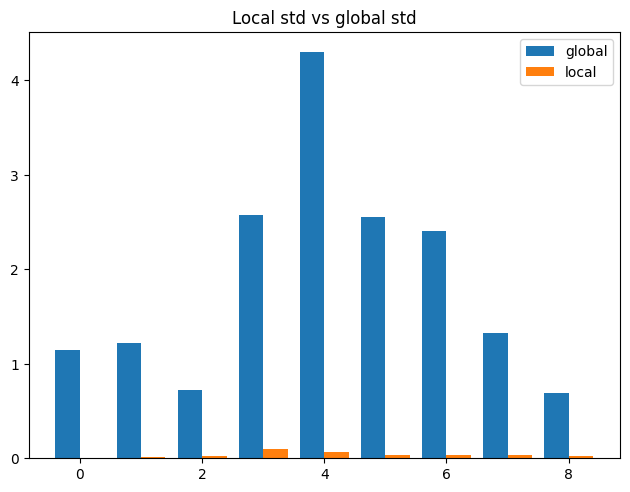

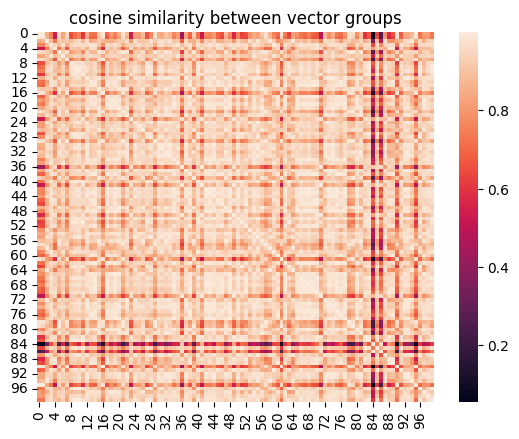

Global cos similarity: 0.8929230297776856, Local cos similarity: 0.9998961998531088
Silhouette score cosine: 0.9300176857936666
Silhouette score euclidean: 0.8794910496667262
Fisher Discriminant Ratio (FDR): 0.878404325789639
Cohen's d: 1.3254465857133881


In [ ]:
test_embeddings_quality(embeddings)

### Magnitude spectrum
Because it works on fix bands it does terribly after shrinking.

In [9]:
embeddings = apply_embedding_function_shrunk(data, lambda x: embedding_vector(x,  100, [(0, 25), (25, 50), (50, 75), (75, 100)])[0])
embeddings.shape

c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=400
  warnings.warn(
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1793
  warnings.warn(
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1844
  warnings.warn(


(100, 6, 18)

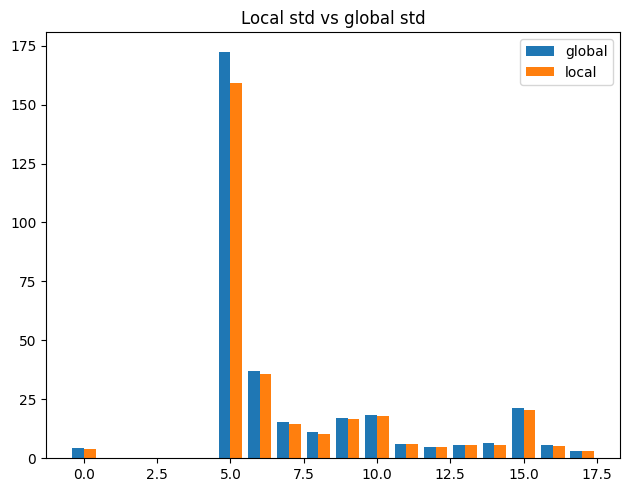

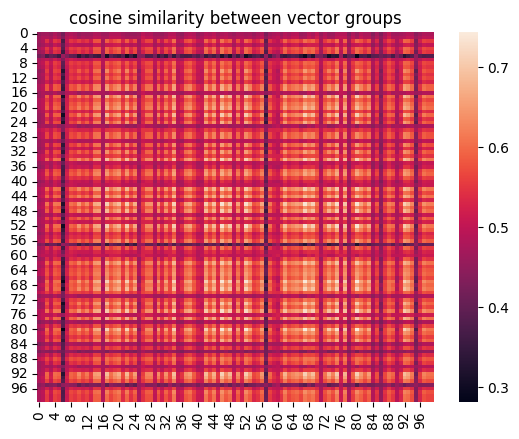

Global cos similarity: 0.5412612037816503, Local cos similarity: 0.5673940385085237
Silhouette score cosine: -0.46682928267073937
Silhouette score euclidean: -0.2748782511254482
Fisher Discriminant Ratio (FDR): 0.001315046235132783
Cohen's d: 0.05128442717107763


In [10]:
test_embeddings_quality(embeddings)

### Sequence to image hu vector

In [9]:
embeddings = apply_embedding_function_shrunk(data, lambda x: s2i_vector(x)[0])
embeddings.shape

(100, 6, 49)

c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\numpy\_core\_methods.py:205: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


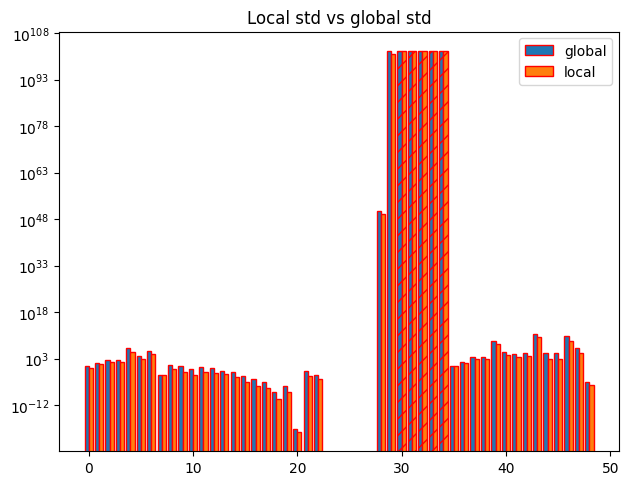

c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2780: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2781: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


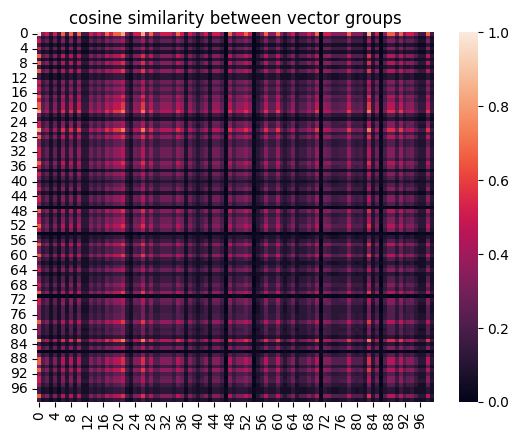

Global cos similarity: 0.18192925760823256, Local cos similarity: 0.2319444444444444
Silhouette score cosine: -0.4119749391363843
Silhouette score euclidean: -0.01961724493622768
Fisher Discriminant Ratio (FDR): 0.007653317708767973
Cohen's d: 0.1237199879467176


c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\sklearn\utils\extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:408: RuntimeWarning: invalid value encountered in add
  distances += XX


In [14]:
test_embeddings_quality(embeddings)

In [27]:
embeddings[0, 0, 20:30]

array([ 5.87827592e-26, -2.00935123e-01,  7.24558063e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.97102503e+49,  3.88493967e+98])

In [26]:
_, names = s2i_vector(np.random.random((1000)))
names[20:30]

['RP_Hu7',
 'GAF_sum_Hu1',
 'GAF_sum_Hu2',
 'GAF_sum_Hu3',
 'GAF_sum_Hu4',
 'GAF_sum_Hu5',
 'GAF_sum_Hu6',
 'GAF_sum_Hu7',
 'GAF_diff_Hu1',
 'GAF_diff_Hu2']

In [ ]:
embeddings_log = apply_embedding_function_shrunk(data, lambda x: s2i_vector(x, log_values=True)[0])

In [11]:
embeddings_log.shape

(100, 6, 49)

c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


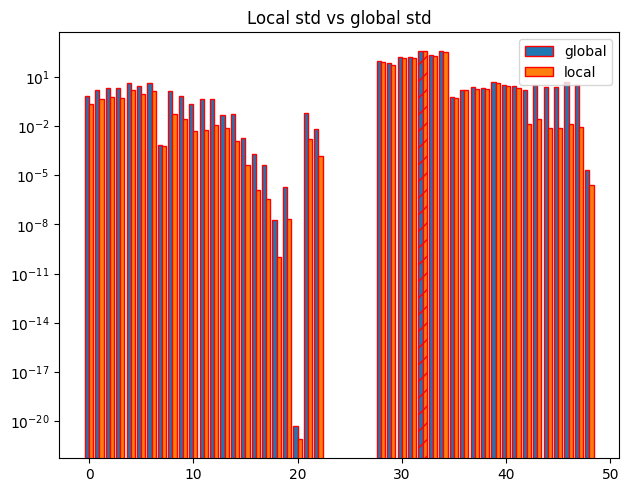

c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2780: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


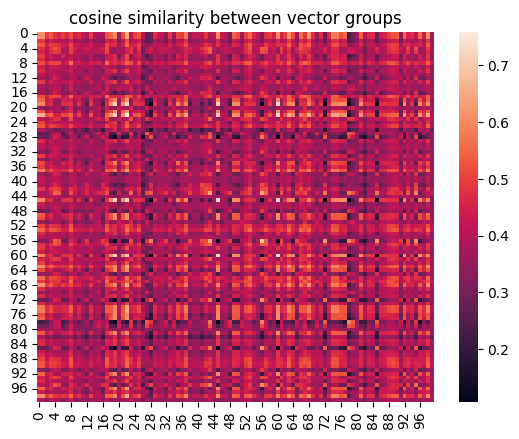

Global cos similarity: 0.3987642476376499, Local cos similarity: 0.48501764856570767
Silhouette score cosine: -0.55021959314577
Silhouette score euclidean: -0.4284615364327402
Fisher Discriminant Ratio (FDR): 0.020916973536302317
Cohen's d: 0.2045334864334069


c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\sklearn\utils\extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:408: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:409: RuntimeWarning: invalid value encountered in add
  distances += YY


In [12]:
test_embeddings_quality(embeddings_log)

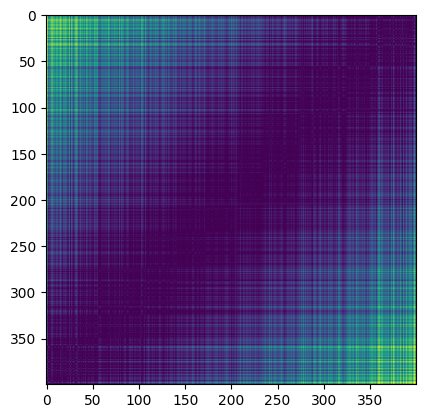

Moments: {'m00': -111698.84523330981, 'm10': -22339385.644162454, 'm01': -22339385.64416244, 'm20': -5721297242.453475, 'm11': -3936788899.2556777, 'm02': -5721297242.453479, 'm30': -1645591689158.883, 'm21': -932092976663.9773, 'm12': -932092976663.9779, 'm03': -1645591689158.8833, 'mu20': -1253496792.8048697, 'mu11': 531011550.39292383, 'mu02': -1253496792.8048801, 'mu30': 38233124.443603516, 'mu21': -254141130.98760986, 'mu12': -254141130.98657227, 'mu03': 38233124.447265625, 'nu20': -0.10046756128953795, 'nu11': 0.04256048822045808, 'nu02': -0.10046756128953879, 'nu30': 9.168917860101454e-06, 'nu21': -6.0947128669431214e-05, 'nu12': -6.094712866918238e-05, 'nu03': 9.168917860979686e-06}
Hu Moments: [-2.00935123e-01  7.24558063e-03  7.37359136e-08  5.36196623e-09
  1.06616800e-16  4.56415801e-10  1.49294392e-27]


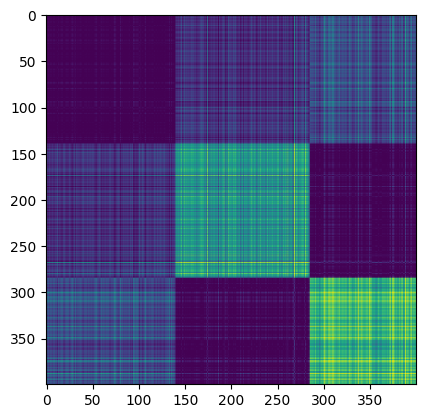

Moments: {'m00': -91559.48742535312, 'm10': -15976673.945635466, 'm01': -15976673.945635473, 'm20': -3988250910.1313, 'm11': -2669142731.813968, 'm02': -3988250910.1313004, 'm30': -1155352340709.2163, 'm21': -626970831772.5857, 'm12': -626970831772.5858, 'm03': -1155352340709.216, 'mu20': -1200400982.801252, 'mu11': 118707195.51608086, 'mu02': -1200400982.80125, 'mu30': -40494476304.45679, 'mu21': 27531435268.673157, 'mu12': 27531435268.67285, 'mu03': -40494476304.45654, 'nu20': -0.14319229076167816, 'nu11': 0.014160231038944716, 'nu02': -0.14319229076167794, 'nu30': -0.015963841422008927, 'nu21': 0.010853516500496888, 'nu12': 0.010853516500496768, 'nu03': -0.01596384142200883}
Hu Moments: [-2.86384582e-01  8.02048572e-04  4.70923303e-03  5.22308416e-05
 -2.59039281e-08  1.47920157e-06 -1.57495189e-21]


In [32]:
from pyts.image import GramianAngularField
import cv2

gaf0 = GramianAngularField(method="summation")
img = gaf0.fit_transform(data[0].reshape(1, -1))[0]
plt.imshow(img)
plt.show()

moments = cv2.moments(img)
hu = cv2.HuMoments(moments)

print("Moments:", moments)
print("Hu Moments:", hu.flatten())

img = gaf0.fit_transform(data[1].reshape(1, -1))[0]
plt.imshow(img)
plt.show()

moments = cv2.moments(img)
hu = cv2.HuMoments(moments)

print("Moments:", moments)
print("Hu Moments:", hu.flatten())

### PAA

In [14]:
embeddings = apply_embedding_function_shrunk(data, lambda x: paa(x, 50))
embeddings.shape

(100, 6, 50)

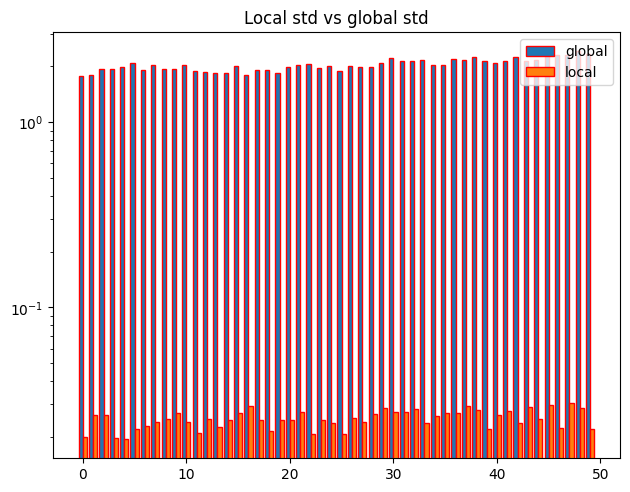

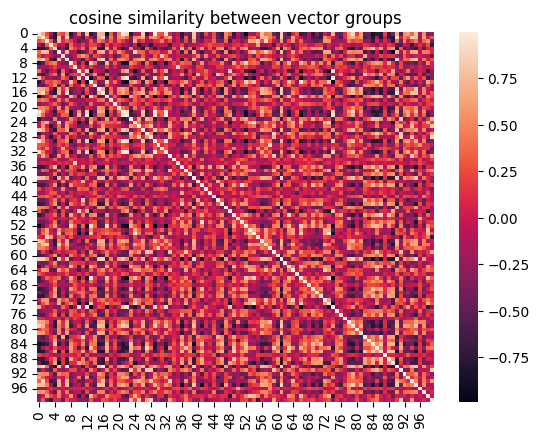

Global cos similarity: 0.019350819236484226, Local cos similarity: 0.9994642263541518
Silhouette score cosine: 0.997199930248346
Silhouette score euclidean: 0.9701091639116294
Fisher Discriminant Ratio (FDR): 5.88789489633361
Cohen's d: 3.4315870661644623


In [15]:
test_embeddings_quality(embeddings)

### SAX

In [16]:
embeddings = apply_embedding_function_shrunk(data, lambda x: sax(x, 50, 20))
embeddings.shape

(100, 6, 50)

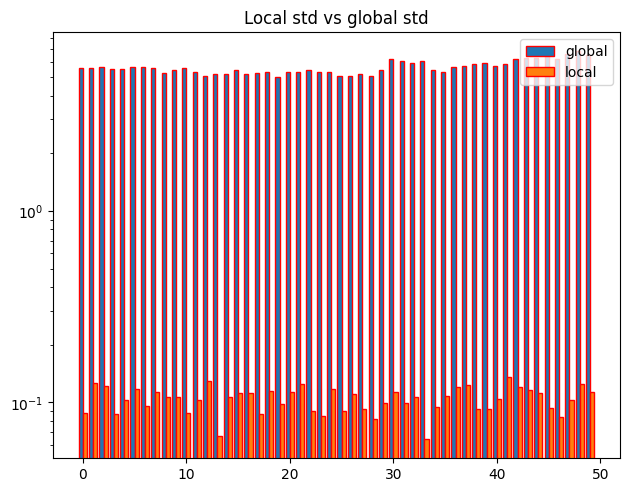

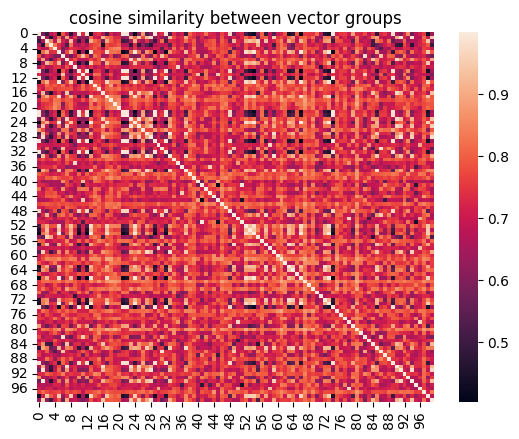

Global cos similarity: 0.7442735652801005, Local cos similarity: 0.9996235222457495
Silhouette score cosine: 0.9820810281148196
Silhouette score euclidean: 0.9062070609060328
Fisher Discriminant Ratio (FDR): 6.536383524004384
Cohen's d: 3.615628167830421


In [17]:
test_embeddings_quality(embeddings)

## Shift invariance

### Simple embedding vector

In [87]:
embeddings = apply_embedding_function_shifts(data, simple_statistics_vector)
embeddings.shape

(100, 6, 9)

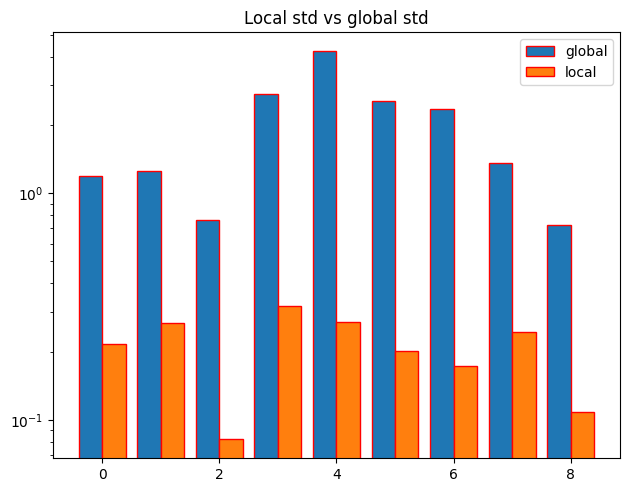

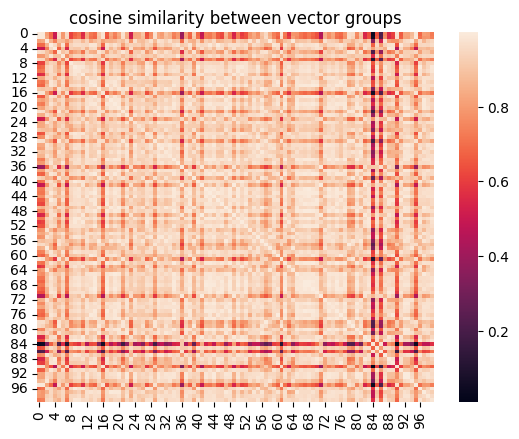

Global cos similarity: 0.8852931033892195, Local cos similarity: 0.9945373481128233
Silhouette score cosine: 0.24253258392724736
Silhouette score euclidean: 0.3549389869959176
Fisher Discriminant Ratio (FDR): 0.7450353865343708
Cohen's d: 1.2206845510076474


In [88]:
test_embeddings_quality(embeddings)

### Magnitude spectrum

In [89]:
embeddings = apply_embedding_function_shifts(data, lambda x: embedding_vector(x,  100, [(0, 25), (25, 50), (50, 75), (75, 100)])[0])
embeddings.shape

c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=400
  warnings.warn(
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=307
  warnings.warn(
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=303
  warnings.warn(
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=341
  warnings.warn(
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=346
  warnings.warn(
c:\Users\krzys\Documents\studi

(100, 6, 18)

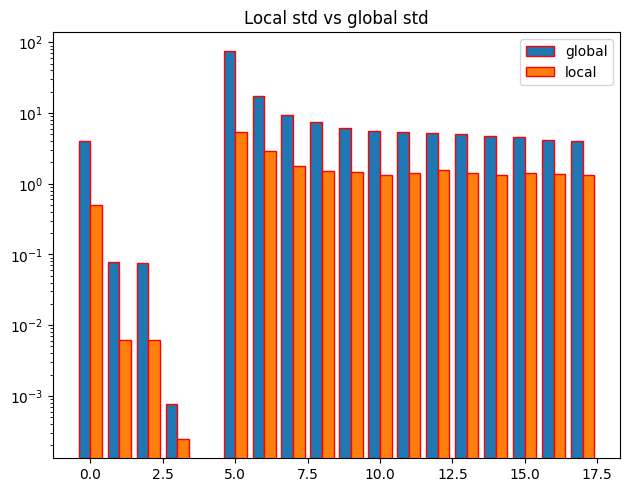

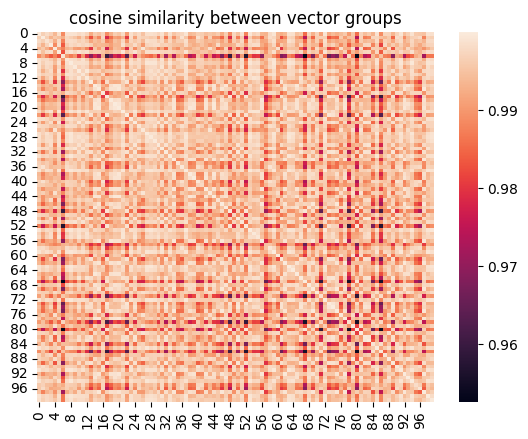

Global cos similarity: 0.9929173277284761, Local cos similarity: 0.9995835378364194
Silhouette score cosine: 0.536567035229311
Silhouette score euclidean: 0.39432932890998934
Fisher Discriminant Ratio (FDR): 1.0859764999569899
Cohen's d: 1.4737547285467754


In [90]:
test_embeddings_quality(embeddings)

### Sequence to image hu vector

In [91]:
embeddings = apply_embedding_function_shifts(data, lambda x: s2i_vector(x)[0])
embeddings.shape

(100, 6, 49)

c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


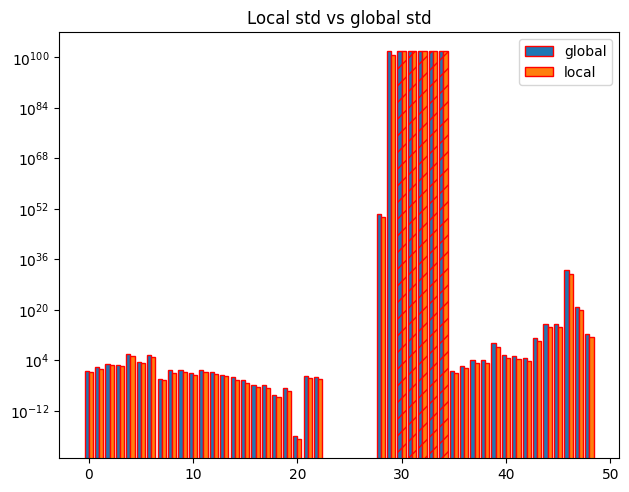

c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2780: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


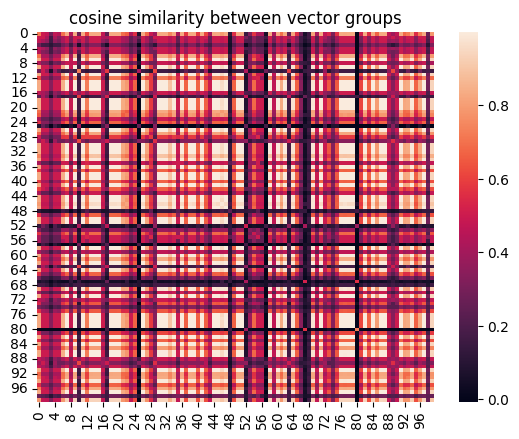

Global cos similarity: 0.5223520950794331, Local cos similarity: 0.6842814484448213
Silhouette score cosine: -0.5357803885681398
Silhouette score euclidean: -0.2659707094204997
Fisher Discriminant Ratio (FDR): 0.05910586081880998
Cohen's d: 0.343819315393449


c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\sklearn\utils\extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:408: RuntimeWarning: invalid value encountered in add
  distances += XX


In [92]:
test_embeddings_quality(embeddings)

### SAX

In [93]:
embeddings = apply_embedding_function_shifts(data, lambda x: sax(x, 50, 20))
embeddings.shape

(100, 6, 50)

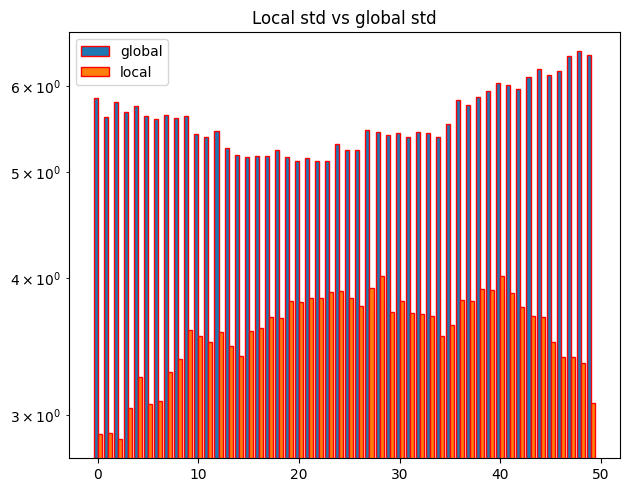

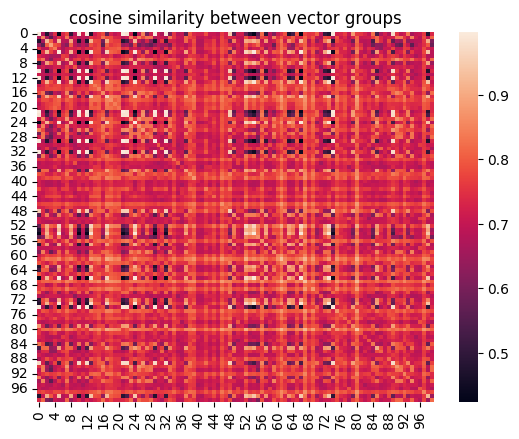

Global cos similarity: 0.7462309228427744, Local cos similarity: 0.8617666759828306
Silhouette score cosine: -0.29357978939979856
Silhouette score euclidean: -0.16565260627160658
Fisher Discriminant Ratio (FDR): 0.47424189554565643
Cohen's d: 0.9739013251306894


In [94]:
test_embeddings_quality(embeddings)